In [60]:
import pandas as pd
import datetime as dt
import simplejson as json
from escapejson import escapejson

# SQLAlchemy
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

from sqlalchemy import Column, Integer, String, Float, Date, null, ForeignKey

In [61]:
def fixJson(str):
    companyStr = str.replace("\'", "\"")
    items = companyStr.split(":")
    cleaned = []    
    for item in items:
        commaItems = item.split(",")
        cleanedCommaItems = []
        for commaItem in commaItems:
            left = commaItem.find("\"")
            right = commaItem.rfind("\"")
            #print(f'{commaItem} {left}, {right}')
            while left != right:
                newleft = commaItem.find("\"", left + 1, right - 1)
                right = commaItem.rfind("\"", left + 1, right - 1)
                left = newleft
                #print(f'{commaItem} {left}, {right}')
                if left > 0 and (right == left): #found only one quote
                    #located the isolated quote !!
                    temp = list(commaItem)
                    temp[left] = "'"
                    commaItem = "".join(temp)
                elif left > 0 and right > 0 and (right != left): #found two quotes
                    temp = list(commaItem)
                    temp[left] = "'"
                    temp[right] = "'"
                    commaItem = "".join(temp)
            cleanedCommaItems.append(commaItem)
        cleaned.append(",".join(cleanedCommaItems))
    result = ":".join(cleaned)
    #print(result)
    return result

In [62]:
# Create tables, classes and databases
# ----------------------------------
class Movie(Base):
    __tablename__ = 'movie'
    movie_id = Column(Integer, primary_key=True, autoincrement=False)
    adult = Column(String(10), nullable=True)
    budget = Column(Float, nullable=True)
    imdb_id = Column(String(40), nullable=True)
    language = Column(String(10), nullable=True)
    title = Column(String(512), nullable=True)
    popularity = Column(Float, nullable=True)
    release_date = Column(Date, nullable=True)
    revenue = Column(Float, nullable=True)
    runtime = Column(Float, nullable=True)
    status = Column(String(10), nullable=True)
    vote_average = Column(Float, nullable=True)
    vote_count = Column(Float, nullable=True)

class Rating(Base):
    __tablename__ = 'rating'
    id = Column(Integer, primary_key=True)
    movie_id = Column(Integer, ForeignKey("movie.movie_id")) #foriegn key
    user_id = Column(Integer)
    rating = Column(Float, nullable=True)
    ts = Column(Float, nullable=True) 
    
class Genres(Base):
    __tablename__ = 'genres'
    genres_id = Column(Integer, primary_key=True, autoincrement=False)
    geners_name = Column(String(10), nullable=True) 
    
class MovieGenres(Base):
    __tablename__ = 'movie_genres'
    genres_id = Column(Integer, primary_key=True, autoincrement=False)
    movie_id =  Column(Integer, primary_key=True, autoincrement=False) 
    
class ProductionCompanies(Base):
    __tablename__ = 'production_companies'
    production_company_id = Column(Integer, primary_key=True, autoincrement=False)
    production_company_name= Column(String(512), nullable=True) 
    
class MovieProductionCompanies(Base):
    __tablename__ = 'movie_production_companies'
    production_company_id = Column(Integer, primary_key=True, autoincrement=False)
    movie_id =Column(Integer, primary_key=True, autoincrement=False)

In [63]:
# Path to sqlite
database_path = "database/combined_data.sqlite"

# Create an engine that can talk to the database
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

# Use this to clear out the db
Base.metadata.drop_all(engine)

# Create a "Metadata" Layer That Abstracts our SQL Database
# ----------------------------------
Base.metadata.create_all(engine)

from sqlalchemy.orm import Session
session = Session(bind=engine)

In [64]:
#import the movies csv file into dataframe
file_movie = "files/movies_metadata.csv"

#columns to import from csv file .. 
col_list = ["adult", "budget", "id", "imdb_id", "original_language", "title", "release_date", "revenue", "runtime", "status", "vote_average", "vote_count", "popularity", "genres", "production_companies" ]
movies_df = pd.read_csv(file_movie,usecols=col_list, low_memory=False)
movies_df.head(5)

,adult,budget,genres,id,imdb_id,original_language,popularity,production_companies,release_date,revenue,runtime,status,title,vote_average,vote_count
0,FALSE,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",2,tt0094675,fi,3.860491,"[{'name': 'Villealfa Filmproduction Oy', 'id':...",10/21/88,0.0,69.0,Released,Ariel,7.1,44.0
1,FALSE,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",3,tt0092149,fi,2.29211,"[{'name': 'Villealfa Filmproduction Oy', 'id':...",10/16/86,0.0,76.0,Released,Shadows in Paradise,7.1,35.0
2,FALSE,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,9.026586,"[{'name': 'Miramax Films', 'id': 14}, {'name':...",12/9/95,4300000.0,98.0,Released,Four Rooms,6.5,539.0
3,FALSE,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",6,tt0107286,en,5.538671,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",10/15/93,12136938.0,110.0,Released,Judgment Night,6.4,79.0
4,FALSE,11000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",11,tt0076759,en,42.149697,"[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...",5/25/77,775398007.0,121.0,Released,Star Wars,8.1,6778.0


In [65]:
#convert budget to number and remove the non-numeric budget
movies_df[["budget"]] = movies_df[["budget"]].apply(pd.to_numeric, errors='coerce')

#remove null or na
movies_df.dropna(subset=['budget'], inplace= True)

#remove zero budget values 
movies_df = movies_df.loc[movies_df["budget"] > 0]

#remove duplicate id from dataframe
movies_df.drop_duplicates(subset='id', inplace=True)
print (len(movies_df))

#convert id to int and remove the non-numeric ids
movies_df[["id"]] = movies_df[["id"]].apply(pd.to_numeric, errors='coerce')

#remove null or na
movies_df.dropna(subset=['id'], inplace= True)

movies_df.head()
#movies_df.dtypes

8880


,adult,budget,genres,id,imdb_id,original_language,popularity,production_companies,release_date,revenue,runtime,status,title,vote_average,vote_count
2,FALSE,4000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,tt0113101,en,9.026586,"[{'name': 'Miramax Films', 'id': 14}, {'name':...",12/9/95,4300000.0,98.0,Released,Four Rooms,6.5,539.0
4,FALSE,11000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",11,tt0076759,en,42.149697,"[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...",5/25/77,775398007.0,121.0,Released,Star Wars,8.1,6778.0
5,FALSE,94000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12,tt0266543,en,25.497794,"[{'name': 'Pixar Animation Studios', 'id': 3}]",5/30/03,940335536.0,100.0,Released,Finding Nemo,7.6,6292.0
6,FALSE,55000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",13,tt0109830,en,48.307194,"[{'name': 'Paramount Pictures', 'id': 4}]",7/6/94,677945399.0,142.0,Released,Forrest Gump,8.2,8147.0
7,FALSE,15000000.0,"[{'id': 18, 'name': 'Drama'}]",14,tt0169547,en,20.726578,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...",9/15/99,356296601.0,122.0,Released,American Beauty,7.9,3438.0


In [66]:
#read each row from the dataframe and store in the movie table
print("Starting Movies Migration")
genresDictionary = {}
companiesDictionary = {}
for index, row in movies_df.iterrows():
    release_dt = null()
    if not pd.isna(row["release_date"]): #check to see if the release_date is not null or not na
        try: #try/except to avoid error due to date converion from string
            release_dt = dt.datetime.strptime(row["release_date"], '%m/%d/%y').date()
        #break
        except ValueError:
            release_dt = null()
            print(row["id"])
            print(f'error processing release_date {row["release_date"]}')
            
    #creating the movie object and adding it to the db session
    movie = Movie(movie_id=int(row["id"]), adult=row["adult"], status=row["status"], title=row["title"],  
                  language=row["original_language"], release_date=release_dt, imdb_id=row["imdb_id"],  
                  budget=float(row["budget"]), popularity=float(row["popularity"]), revenue=float(row["revenue"]), 
                  runtime=float(row["runtime"]), vote_average=float(row["vote_average"]), vote_count=float(row["vote_count"]))
    session.add(movie)
    
    genreStr = row["genres"]
    genreStr = genreStr.replace("\'", "\"")
    genreJsonArray = json.loads(genreStr)

    for genreJson in genreJsonArray:
        movie_genres = MovieGenres(genres_id=int(genreJson["id"]),movie_id=int(row["id"]) )
        session.add(movie_genres)
        genresDictionary[genreJson["id"]] = genreJson["name"]

    companyStr = row["production_companies"]
    try: #try/except to avoid error due to date converion from string
        #cleaning the json
        companyStr = fixJson(row["production_companies"])
        companyJsonArray = json.loads(companyStr)
        
        for companyJson in companyJsonArray:
            movie_production_company = MovieProductionCompanies(production_company_id=int(companyJson["id"]),movie_id=int(row["id"]) )
            session.add(movie_production_company)
            companiesDictionary[companyJson["id"]] = companyJson["name"]
        #break
    except json.decoder.JSONDecodeError:
        print(row["id"])
        print(fixJson(row["production_companies"]))
        print(f'error processing production_companies {row["production_companies"]}')
            
    
session.commit() #save the session
print("Finished Movies Migration")

Starting Movies Migration
Finished Movies Migration


In [67]:
#print(genresDictionary)
#migrate the genres dictionary to the database
for key in genresDictionary:
    genre = Genres(genres_id=key, geners_name=genresDictionary[key])
    session.add(genre)
    
session.commit() #save the session

In [68]:
#print(companiesDictionary)
#migrate the companies dictionary to the database
for key in companiesDictionary:
    company = ProductionCompanies(production_company_id=key, production_company_name=companiesDictionary[key])
    session.add(company)
    
session.commit() #save the session

In [69]:
data = pd.read_sql("SELECT * FROM genres", conn)
data.head()

,genres_id,geners_name
0,12,Adventure
1,14,Fantasy
2,16,Animation
3,18,Drama
4,27,Horror


In [70]:
data = pd.read_sql("SELECT * FROM movie_genres", conn)
data.head()

,genres_id,movie_id
0,80,5
1,35,5
2,12,11
3,28,11
4,878,11


In [71]:
data = pd.read_sql("SELECT * FROM production_companies", conn)
data.head()

,production_company_id,production_company_name
0,1,Lucasfilm
1,2,Walt Disney Pictures
2,3,Pixar Animation Studios
3,4,Paramount Pictures
4,5,Columbia Pictures


In [72]:
data = pd.read_sql("SELECT * FROM movie_production_companies", conn)
data.head()

,production_company_id,movie_id
0,14,5
1,59,5
2,1,11
3,306,11
4,3,12


In [73]:
# Saving a New Clean CSV file 

movies_df.to_csv("files/clean_movies.csv")


In [74]:
#example query
movie_list = session.query(Movie)
for movie in movie_list:
    print(f'{movie.movie_id}' + " " + f'{movie.release_date.strftime("%m/%d/%Y")}')

5 12/09/1995
11 05/25/1977
12 05/30/2003
13 07/06/1994
14 09/15/1999
15 04/30/2041
16 05/17/2000
18 05/07/1997
19 01/10/2027
22 07/09/2003
24 10/10/2003
25 11/04/2005
26 02/05/2004
27 07/16/2004
28 08/15/1979
33 08/07/1992
35 07/25/2007
38 03/19/2004
55 06/16/2000
58 06/20/2006
59 09/23/2005
62 04/10/2068
63 12/29/1995
64 03/14/2002
65 11/08/2002
66 02/14/1997
68 02/20/1985
69 09/13/2005
70 12/15/2004
71 05/18/2000
73 10/30/1998
74 06/28/2005
75 12/12/1996
76 01/27/1995
77 10/11/2000
78 06/25/1982
79 12/19/2002
80 02/10/2004
81 03/11/1984
82 07/27/2006
83 08/06/2004
85 06/12/1981
86 02/10/2006
87 05/23/1984
88 08/21/1987
89 05/24/1989
90 11/29/1984
91 12/01/2033
95 07/01/1998
96 05/18/1987
97 07/09/1982
98 05/01/2000
99 04/19/1999
100 03/05/1998
101 09/14/1994
103 02/07/1976
104 08/20/1998
105 07/03/1985
106 06/11/1987
107 09/01/2000
111 12/08/1983
114 03/23/1990
115 03/06/1998
116 10/26/2005
117 06/02/1987
118 07/13/2005
120 12/18/2001
121 12/18/2002
122 12/01/2003
123 11/15/1978
128 

13016 06/01/2007
13018 04/24/2008
13019 09/05/2007
13025 09/08/2007
13027 09/25/2008
13041 12/18/1970
13051 10/15/2008
13053 11/21/2008
13054 09/07/2007
13055 09/22/2002
13056 12/05/2008
13059 02/22/2007
13063 10/01/1993
13064 09/17/1993
13067 04/16/2007
13072 04/30/2007
13075 09/08/2006
13079 09/08/2007
13090 01/18/2008
13092 10/02/2008
13120 04/27/2007
13122 11/01/1991
13123 06/06/2008
13150 09/09/2008
13153 07/24/1992
13154 08/23/1991
13155 06/21/1985
13159 05/11/2007
13160 02/01/2008
13177 09/07/2007
13179 10/27/2008
13183 03/05/2009
13184 08/21/2008
13185 03/03/2006
13186 08/25/2007
13191 04/28/2008
13192 10/29/1988
13195 09/01/2007
13197 02/19/2006
13200 10/07/2008
13207 02/11/2009
13209 05/26/2006
13221 01/18/2008
13223 12/09/2008
13243 09/07/2007
13245 02/01/2002
13249 09/13/2006
13250 07/27/2007
13251 02/13/2007
13252 09/11/2007
13256 08/07/2008
13257 09/14/2007
13258 01/22/2007
13259 07/25/2008
13275 01/27/2006
13279 09/19/2008
13282 04/27/1975
13291 08/23/2008
13310 01/26/20

AttributeError: 'NoneType' object has no attribute 'strftime'

In [75]:
#example query

data = pd.read_sql("SELECT * FROM movie", conn)
#data.head()
print(data)

      movie_id  adult      budget    imdb_id language  \
0            5  FALSE   4000000.0  tt0113101       en   
1           11  FALSE  11000000.0  tt0076759       en   
2           12  FALSE  94000000.0  tt0266543       en   
3           13  FALSE  55000000.0  tt0109830       en   
4           14  FALSE  15000000.0  tt0169547       en   
...        ...    ...         ...        ...      ...   
8875    452068  FALSE   4000000.0  tt5352846       en   
8876    455043  FALSE  25000000.0  tt6083388       zh   
8877    457307  FALSE      7200.0  tt6679360       ru   
8878    460846  FALSE  15000000.0  tt3501112       en   
8879    468707  FALSE   1254040.0  tt5742932       fi   

                                 title  popularity release_date      revenue  \
0                           Four Rooms    9.026586   1995-12-09    4300000.0   
1                            Star Wars   42.149697   1977-05-25  775398007.0   
2                         Finding Nemo   25.497794   2003-05-30  940335536.

In [76]:
#import the ratings csv file into dataframe

file_ratings = "files/ratings.csv"
ratings_df = pd.read_csv(file_ratings, low_memory=False)
ratings_df.head(5)
ratings_df.dtypes

userId       float64
movieId      float64
rating       float64
timestamp    float64
dtype: object

In [77]:
#read each row from the dataframe and store in the rating table

print("Starting Ratings Migration")
for index, row in ratings_df.iterrows():
    try: #to avoid errors from converting na or null to int
        rating = Rating(movie_id=int(row["movieId"]), rating=row["rating"], user_id=row["userId"], ts=row["timestamp"])
        session.add(rating)
        #csv_links['timestamp'] = pd.to_datetime(csv_rating['timestamp'])

    except ValueError:
        rating = null()
    
session.commit()
print("Finished Ratings Migration")

Starting Ratings Migration
Finished Ratings Migration


In [78]:
#number of times a movie has been rated
data = pd.read_sql("SELECT * from rating", conn)
data.head()

,id,movie_id,user_id,rating,ts
0,1,1,7,3.0,8.518667e+08
1,2,1,9,4.0,9.386292e+08
2,3,1,13,5.0,1.331380e+09
3,4,1,15,2.0,9.979383e+08
4,5,1,19,3.0,8.551901e+08


In [79]:
#number of times a movie has been rated
data = pd.read_sql("SELECT movie_id, count(*) as cnt FROM rating group by movie_id", conn)
data.head()

,movie_id,cnt
0,1,247
1,2,107
2,3,59
3,4,13
4,5,56


In [80]:
#average rating for each movie
data = pd.read_sql("SELECT movie_id, avg(rating) as average FROM rating group by movie_id", conn)
data.head()

,movie_id,average
0,1,3.872470
1,2,3.401869
2,3,3.161017
3,4,2.384615
4,5,3.267857


In [81]:
#average rating for each user
data = pd.read_sql("SELECT user_id, avg(rating) as avg FROM rating group by user_id", conn)
data.head()

,user_id,avg
0,1,2.550000
1,2,3.486842
2,3,3.568627
3,4,4.348039
4,5,3.910000


In [82]:
#average rating for each movie
data = pd.read_sql("SELECT movie_id, avg(rating) as average FROM rating group by movie_id order by average desc ", conn)
data.head(100)

,movie_id,average
0,163949,5.0
1,162542,5.0
2,161944,5.0
3,160590,5.0
4,156025,5.0
...,...,...
95,83411,5.0
96,83359,5.0
97,83318,5.0
98,82608,5.0


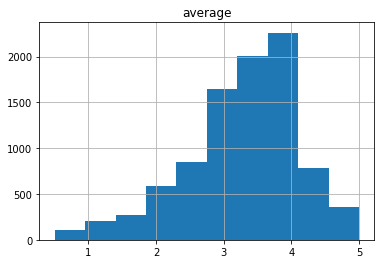

In [83]:
hist = data.hist("average")